## COLAB PRO SETTINGS

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 20 13:49:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Instructions to run the notebook


1. Original FMA Dataset GitHub repository - https://github.com/mdeff/fma

2. Downloading the data from this and loading it into the drive takes a long time and space since it is 7.2 GB, so instead we are using the FMA Small from Kaggle using Kaggle API

FMA Kaggle Dataset - https://www.kaggle.com/datasets/imsparsh/fma-free-music-archive-small-medium

We are using the Small dataset from the different variations of the data available

3. Download your Kaggle API file kaggle.json and upload into the colab by running the cells below


# Importing libraries and extracting FMA Small Dataset

In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 31.6 MB/s eta 0:00:00


In [3]:
# Importing all libraries
import os
import ast
import random
import math
import librosa
import numpy as np
import pandas as pd
from PIL import Image
import IPython.display as ipd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    LayerNormalization,
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
from google.colab import drive, auth
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from google.colab import drive, auth

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Upload your Kaggle API key file - kaggle.json
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d imsparsh/fma-free-music-archive-small-medium -p /content/ --unzip

100% 29.8G/29.8G [28:22<00:00, 20.1MB/s]
100% 29.8G/29.8G [28:22<00:00, 18.8MB/s]


# EDA & Pre-processing

In [ ]:
# Directory where mp3 audio files are stored.
AUDIO_DIR = "/content/fma_small/fma_small/"

In [ ]:
# Function to load multiple csv files to understand features
def load(filepath):
    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [ ]:
# Processing the Kaggle dataset
base_path = "/content/drive/My Drive/DS 5500"
metadata_folder_path = f'{base_path}/fma_metadata'

# Load metadata and features.
tracks = load(f'{metadata_folder_path}/tracks.csv')
genres = load(f'{metadata_folder_path}/genres.csv')
features = load(f'{metadata_folder_path}/features.csv')
echonest = load(f'{metadata_folder_path}/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [ ]:
tracks.head()

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [ ]:
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


In [ ]:
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  

[5 rows x 518 columns]

In [ ]:
echonest.head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        ...  \
                                           metadata                     ...   
         speechiness    tempo   valence  album_date         album_name  ...   
track_id                                                                ...   
2           0.159310  165.922  0.576661         NaN                NaN  ...   
3           0.461818  126.957  0.269240         NaN                NaN  ...   
5           0.124595  100.260  0.621661         NaN                NaN  ...   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker  ...   
134         0.525519  114.290  0.894072         NaN                NaN  ...   

                                                                              \
         temporal_features                                                     
                       214        215       216       217       218      219   
track_id                                                                       
2                -1.992303   6.805694  0.233070  0.192880  0.027455  0.06408   
3                -1.582331   8.889308  0.258464  0.220905  0.081368  0.06413   
5                -2.288358  11.527109  0.256821  0.237820  0.060122  0.06014   
10               -3.662988  21.508228  0.283352  0.267070  0.125704  0.08082   
134              -1.452696   2.356398  0.234686  0.199550  0.149332  0.06440   

                                                     
                                                     
               220       221        222         223  
track_id                                             
2          3.67696   3.61288  13.316690  262.929749  
3          6.08277   6.01864  16.673548  325.581085  
5          5.92649   5.86635  16.013849  356.755737  
10         8.41401   8.33319  21.317064  483.403809  
134       11.26707  11.20267  26.454180  751.147705  

[5 rows x 249 columns]

In [ ]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


In [ ]:
genres.sort_values('#tracks').head(10)

,#tracks,parent,title,top_level
genre_id,,,,
175,0,86,Bollywood,2
178,0,4,Be-Bop,4
377,1,19,Deep Funk,14
173,4,86,N. Indian Traditional,2
493,4,651,Western Swing,9
374,9,20,Banter,20
808,12,46,Salsa,2
174,17,86,South Indian Traditional,2
465,18,20,Musical Theater,20


In [ ]:
# Function to get the filepath of each audio mp3 file using track id as input
def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [ ]:
filename = get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: /content/fma_small/fma_small/000/000002.mp3
Duration: 29.98s, 1321967 samples


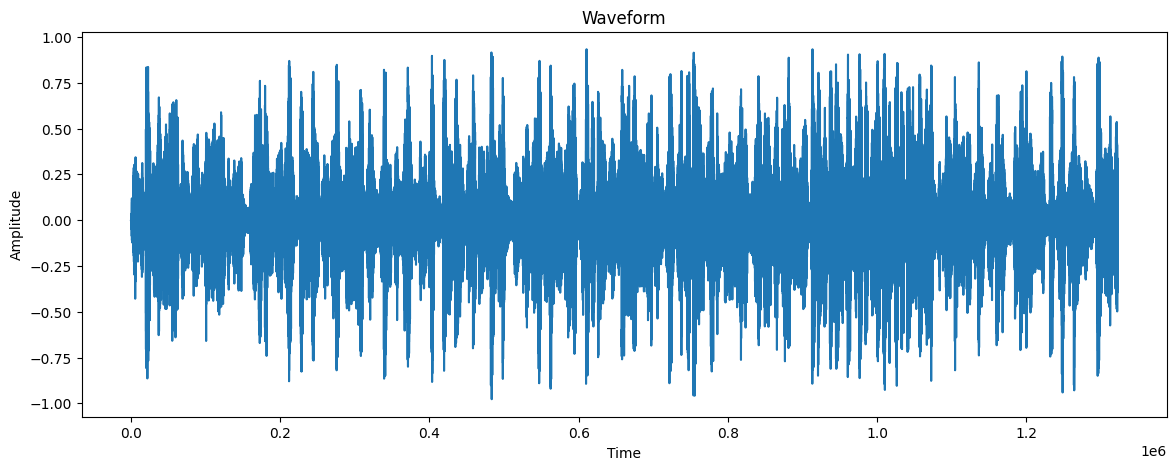

In [ ]:
# Plot waveform
plt.figure(figsize=(14, 5))
plt.plot(x)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

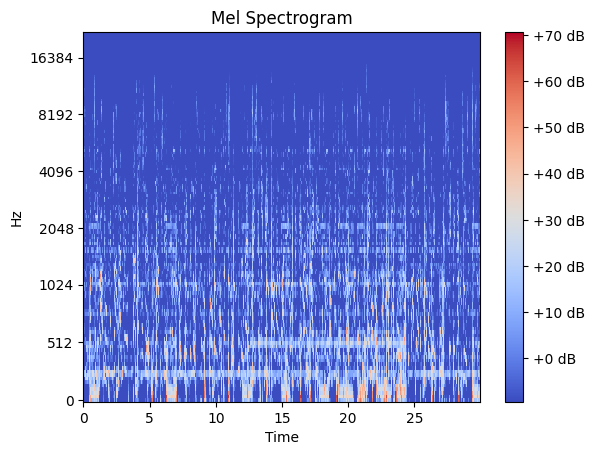

In [ ]:
# Compute spectrogram
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

# Display spectrogram
librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

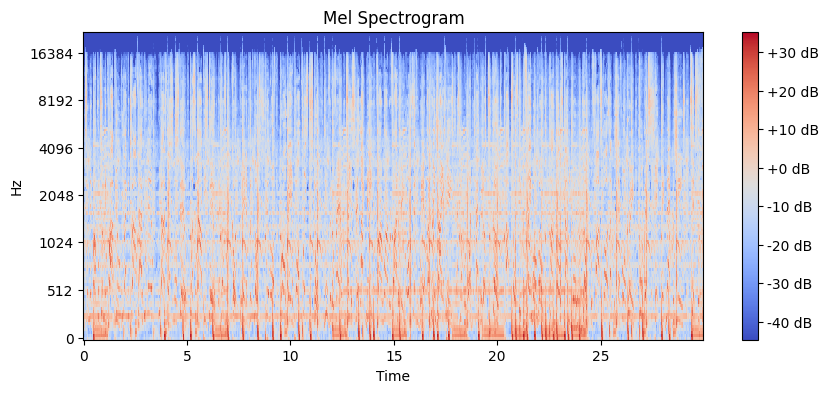

In [ ]:
# Load the audio file
audio_path = get_audio_path(AUDIO_DIR, 2)
y, sr = librosa.load(audio_path, sr=None)

# Compute the mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to log scale
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

# Display the mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

# Data Preparation and understanding data

In [ ]:
small = tracks['set', 'subset'] <= 'small'
train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train_initial = tracks.loc[small & train, ('track', 'genre_top')]
y_test_initial = tracks.loc[small & test, ('track', 'genre_top')]
y_val_initial = tracks.loc[small & val, ('track', 'genre_top')]
X_train_initial = features.loc[small & train, 'mfcc']
X_test_initial = features.loc[small & test, 'mfcc']
X_val_initial = features.loc[small & val, 'mfcc']

small_tracks = tracks[tracks['set', 'subset'] <= 'small']
small_track_ids = small_tracks.index.tolist()
print('Total examples', small_tracks.shape)
print('{} training examples, {} testing examples, {} validation examples'.format(y_train_initial.size, y_test_initial.size, y_val_initial.size))
print('{} features, {} classes'.format(X_train_initial.shape[1], np.unique(y_train_initial).size))

Total examples (8000, 52)
6400 training examples, 800 testing examples, 800 validation examples
140 features, 8 classes


(array(['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental',
       'International', 'Pop', 'Rock'], dtype=object), array([800, 800, 800, 800, 800, 800, 800, 800]))


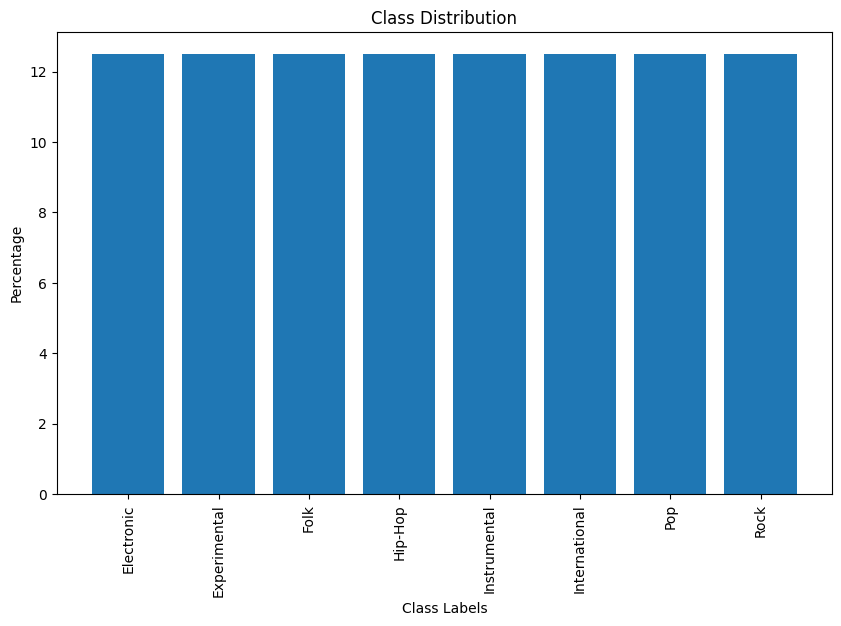

In [ ]:
# Assuming you have already loaded your training labels into the y_train variable

# Count the occurrences of each class in the training set
class_counts = np.unique(y_train_initial, return_counts=True)
print(class_counts)

# Get the class labels and their corresponding counts
class_labels = class_counts[0]
class_counts = class_counts[1]

# Calculate the class distribution as percentages
class_distribution = class_counts / np.sum(class_counts) * 100

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_distribution)
plt.xlabel('Class Labels')
plt.ylabel('Percentage')
plt.title('Class Distribution')
plt.xticks(rotation='vertical')
plt.show()


In [ ]:
# To undertsand the structure of labels
y_train_initial[:10]

track_id
2      Hip-Hop
5      Hip-Hop
10         Pop
140       Folk
141       Folk
190       Folk
193       Folk
194       Folk
197       Folk
200       Folk
Name: (track, genre_top), dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock',
                          'Soul-RnB', 'Spoken']

In [ ]:
# To understand the characteristics of the audio file - duration, channels
for track_id in X_train_initial.index.tolist()[:3]:
  # Load an audio file
  audio_path = get_audio_path(AUDIO_DIR, track_id)
  print(audio_path)
  audio, sr = librosa.load(audio_path, sr=None)
  num_channels = audio.ndim

  # Get the sampling rate
  sampling_rate = librosa.get_samplerate(audio_path)
  duration = len(audio) / sampling_rate

  print(num_channels, audio.shape)
  print("Sampling rate:", sampling_rate)
  print("Duration:", duration)

  if num_channels == 1:
      print("Audio file is mono.")
  elif num_channels == 2:
      print("Audio file is stereo.")
  else:
      print("Unsupported number of channels.")

/content/fma_small/fma_small/000/000002.mp3
1 (1321967,)
Sampling rate: 44100
Duration: 29.976575963718822
Audio file is mono.
/content/fma_small/fma_small/000/000005.mp3
1 (1323119,)
Sampling rate: 44100
Duration: 30.00269841269841
Audio file is mono.
/content/fma_small/fma_small/000/000010.mp3
1 (1321967,)
Sampling rate: 44100
Duration: 29.976575963718822
Audio file is mono.


# Conversion to Spectrograms

Some files are corrupted and they are avoided

### Trial Code to produce spectrogram, not mel spectrograms

In [ ]:
# # Define target image dimensions
# image_width = 224
# image_height = 224
# num_channels = 3

# def get_spectrogram(data):
#   converted_spectrograms = []
#   rejected_files = []
#   # Iterate over the train dataset
#   for track_id in data.index.tolist():
#     try:
#       # Get the audio file path
#       filename = get_audio_path(AUDIO_DIR, track_id)
#       # print('Track ID: {}, File: {}'.format(track_id, filename))

#       # Load the audio file
#       x, sr = librosa.load(filename, sr=None, mono=True)

#       # Check if the audio is empty or too short
#       if len(x) == 0:
#         print(f"Audio file {filename} is empty.")
#         rejected_files.append(filename)
#         continue

#       # Convert to spectrogram
#       spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)

#       # Shape is (1025, 2582)
#       # print(spectrogram.shape)

#       # Normalize the spectrogram to [0, 1]
#       spectrogram_normalized = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))

#       # # Convert the spectrogram array to uint8 data type
#       # spectrogram_uint8 = (spectrogram_normalized * 255).astype(np.uint8)

#       # Create a PIL image from the spectrogram array
#       spectrogram_image = Image.fromarray(spectrogram_uint8)

#       # Convert the grayscale image to RGB
#       spectrogram_image_rgb = spectrogram_image.convert('RGB')

#       # Resize the image
#       image = spectrogram_image_rgb.resize((image_width, image_height))

#       # Convert the image to a NumPy array
#       image_array = np.array(image)

#       # Normalize the pixel values to [0, 1]
#       image_array_normalized = image_array / 255.0

#       # print(image_array_normalized.shape)

#       # # Convert the array to a TensorFlow tensor
#       # tensor_image = tf.convert_to_tensor(image_array_normalized, dtype=tf.float32)

#       # # Add an extra dimension for the batch size
#       # tensor_image = tf.expand_dims(tensor_image, axis=0)

#       converted_spectrograms.append(image_array_normalized)
#     except Exception as e:
#       print(f"Could not process file {filename}: {e}")
#       if filename not in rejected_files:
#         rejected_files.append(filename)

#   print(rejected_files)

#   return converted_spectrograms

### Method 1 - Conversion to Mel Spectrograms

In [ ]:
# # Define target image dimensions
# image_width = 72
# image_height = 72
# num_channels = 1

# def get_spectrogram(data):
#     converted_spectrograms = []
#     rejected_files = []

#     for track_id in data.index.tolist():
#         try:
#             # Get the audio file path
#             filename = get_audio_path(AUDIO_DIR, track_id)

#             # Load the audio file
#             x, sr = librosa.load(filename, sr=None, mono=True)

#             # Check if the audio is empty or too short
#             if len(x) == 0:
#                 print(f"Audio file {filename} is empty.")
#                 rejected_files.append(filename)
#                 continue

#             # Compute the mel spectrogram
#             mel_spectrogram = librosa.feature.melspectrogram(y=x, sr=sr)
#             # numpy array of shape (128, 2582)
#             # print(type(mel_spectrogram), mel_spectrogram.shape)

#             # Convert to log scale
#             log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
#             # print(log_mel_spectrogram)

#             # Normalize the spectrogram to [0, 1]
#             spectrogram_normalized = (log_mel_spectrogram - np.min(log_mel_spectrogram)) / (np.max(log_mel_spectrogram) - np.min(log_mel_spectrogram))
#             # print(spectrogram_normalized , type(spectrogram_normalized), spectrogram_normalized.shape)

#             # # Convert the spectrogram array to uint8 data type - only needed to reduce memory
#             # spectrogram_uint8 = (spectrogram_normalized * 255).astype(np.uint8)

#             # Create a PIL image from the spectrogram array
#             spectrogram_image = Image.fromarray(spectrogram_normalized)
#             # <class 'PIL.Image.Image'> (2582, 128)
#             # print(type(spectrogram_image), spectrogram_image.size)

#             # mode = spectrogram_image.mode
#             # print("Number of channels:", len(mode))

#             # bands = spectrogram_image.getbands()
#             # num_channels = len(bands)
#             # print("Number of channels:", num_channels)

#             # # Convert the grayscale image to RGB
#             # spectrogram_image_rgb = spectrogram_image.convert('RGB')

#             # Resize the image
#             image = spectrogram_image.resize((image_width, image_height))
#             # print(image.size)

#             # Convert the image to a NumPy array
#             image_array = np.array(image)
#             # print(image_array.shape, image_array)

#             # Add an extra dimension for the batch size
#             image_array = tf.expand_dims(image_array, axis=-1)
#             # print(image_array.shape, image_array)

#             # Convert to TensorFlow tensor
#             image_tensor = tf.convert_to_tensor(image_array)
#             # print("Final Shape", image_tensor.shape)

#             converted_spectrograms.append(image_tensor)
#         except Exception as e:
#             print(f"Could not process file {filename}: {e}")
#             if filename not in rejected_files:
#                 rejected_files.append(filename)

#     print("Rejected Files:", rejected_files)
#     return converted_spectrograms

In [ ]:
print(len(X_train_initial.index.tolist()), len(X_test_initial.index.tolist()), len(y_train_initial), len(y_test_initial))

6400 800 6397 800


In [ ]:
X_train_images = get_spectrogram(X_train_initial)
# X_train_images = get_spectrogram(X_train_initial[:3200])
# ['/content/fma_small/fma_small/099/099134.mp3', '/content/fma_small/fma_small/108/108925.mp3', '/content/fma_small/fma_small/133/133297.mp3']

<ipython-input-20-3eaa33bf4d2c>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load(filename, sr=None, mono=True)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-20-3eaa33bf4d2c>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load(filename, sr=None, mono=True)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-20-3eaa33bf4d2c>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load(filename, sr=None, mono=True)
/usr/local/lib/pyt

Could not process file /content/fma_small/fma_small/099/099134.mp3: 


<ipython-input-20-3eaa33bf4d2c>:34: RuntimeWarning: invalid value encountered in true_divide
  spectrogram_normalized = (log_mel_spectrogram - np.min(log_mel_spectrogram)) / (np.max(log_mel_spectrogram) - np.min(log_mel_spectrogram))
<ipython-input-20-3eaa33bf4d2c>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load(filename, sr=None, mono=True)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/fma_small/fma_small/108/108925.mp3: 


<ipython-input-20-3eaa33bf4d2c>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load(filename, sr=None, mono=True)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/fma_small/fma_small/133/133297.mp3: 
Rejected Files: ['/content/fma_small/fma_small/099/099134.mp3', '/content/fma_small/fma_small/108/108925.mp3', '/content/fma_small/fma_small/133/133297.mp3']


In [ ]:
# Modify y_train based on files rejected during spectrogram conversion
train_rejected_files = ['/content/fma_small/fma_small/099/099134.mp3', '/content/fma_small/fma_small/108/108925.mp3', '/content/fma_small/fma_small/133/133297.mp3']

if len(train_rejected_files) > 0:
    rejected_track_ids = [os.path.splitext(os.path.basename(file))[0].lstrip('0') for file in train_rejected_files]
    print(rejected_track_ids)

    # Convert y_train index to string for comparison
    y_train_str_index = y_train_initial.index.astype(str)

    y_train_filtered = y_train_initial.loc[~y_train_str_index.isin(rejected_track_ids)]
    print(y_train_filtered.shape)

    # Filter y_train based on the rejected indices
    y_train_rejected = y_train_initial[y_train_str_index.isin(rejected_track_ids)]
    print(y_train_rejected.shape)

    # Update y_train with the filtered labels
    y_train_initial = y_train_filtered

['99134', '108925', '133297']
(6397,)
(3,)


In [ ]:
np.save('X_train.npy', X_train_images)
files.download('X_train.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_test_images = get_spectrogram(X_test_initial)
# X_test_images = get_spectrogram(X_test[:400])

Rejected Files: []


In [ ]:
np.save('X_test.npy', X_test_images)
files.download('X_test.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_val_images = get_spectrogram(X_val_initial)
# X_val_images = get_spectrogram(X_val[:400])

Rejected Files: []


In [ ]:
np.save('X_val.npy', X_val_images)
files.download('X_val.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(len(X_train_images), len(X_test_images), len(X_val_images), len(y_train_initial), len(y_test_initial), len(y_val_initial))
print(type(X_train_images), type(X_test_images), type(X_val_images), type(y_train_initial), type(y_test_initial), type(y_val_initial))

6397 800 800 6397 800 800
<class 'list'> <class 'list'> <class 'list'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [ ]:
# # Save and Download the files
# np.save('y_train.npy', y_train_initial)
# np.save('y_val.npy', y_val_initial)
# np.save('y_test.npy', y_test_initial)
# files.download('y_train_initial.npy')
# files.download('y_val_initial.npy')
# files.download('y_test_initial.npy')

In [ ]:
# # Load the arrays from the files
# X_train = np.load('/content/X_train.npy', allow_pickle=True)
# y_train = np.load('/content/y_train.npy', allow_pickle=True)
# X_val = np.load('/content/X_val.npy', allow_pickle=True)
# y_val = np.load('/content/y_val.npy', allow_pickle=True)

### Method 2 - Conversion to Mel Spectrograms similar to the methods used for CNN model

In [108]:
data_dir = '/content/fma_small/fma_small'  # Set the path to the fma_small directory
tracks_file = os.path.join(data_dir, 'tracks.csv')
# Define the root path to the FMA dataset directory
fma_dir = '/content/'

# Load the tracks metadata
tracks = pd.read_csv(os.path.join(fma_dir, 'fma_metadata', 'tracks.csv'), header=[0, 1], index_col=0)


# Define the top-level genres you want to process
top_level_genres = ['Pop','Hip-Hop','Rock','Experimental','Folk','Instrumental','Electronic','International']

# Prepare empty dictionary to store the Mel spectrograms
mel_spectrograms = {}

for top_level_genre in top_level_genres:
    mel_spectrograms[top_level_genre] = []  # Initialize empty list for this top-level genre

# Traverse through the audio files directory
audio_dir = os.path.join(fma_dir, 'fma_small', 'fma_small')
for folder in os.listdir(audio_dir):
    folder_path = os.path.join(audio_dir, folder)
    if not os.path.isdir(folder_path):
        continue  # Skip non-folder files

    for file in os.listdir(folder_path):
        # Extract the track ID from the file name
        track_id = int(os.path.splitext(file)[0])
        genre_label = ('track', 'genre_top')

        # Get the top-level genre for the current track
        try:
            top_level_genre = tracks.loc[track_id, genre_label]
            # print(top_level_genre)
        except IndexError:
            continue

        # Check if the top-level genre is in the specified genres list
        if top_level_genre in top_level_genres:
            # Construct the file path for the audio clip
            file_path = os.path.join(folder_path, file)

            try:
                # Load audio file
                y, sr = librosa.load(file_path)
                y, _ = librosa.effects.trim(y)

                # Compute Mel spectrogram for the clip
                mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

                # Convert to log scale
                log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

                # Append log Mel spectrogram to list for this top-level genre
                mel_spectrograms[top_level_genre].append(log_mel_spectrogram)

            except Exception as e:
                print(f"Could not process file {file_path}: {e}")

<ipython-input-108-a6a33fefad5e>:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/fma_small/fma_small/108/108925.mp3: 


<ipython-input-108-a6a33fefad5e>:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/fma_small/fma_small/099/099134.mp3: 


<ipython-input-108-a6a33fefad5e>:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/fma_small/fma_small/133/133297.mp3: 


<ipython-input-108-a6a33fefad5e>:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-108-a6a33fefad5e>:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-108-a6a33fefad5e>:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: Futur

## Inspecting size of mel spectrogram

Shape obtained for each mel spectrogram is (128, 1291) for 30 second original clip.

In [111]:
print(mel_spectrograms['Pop'][0].shape)

(128, 1291)


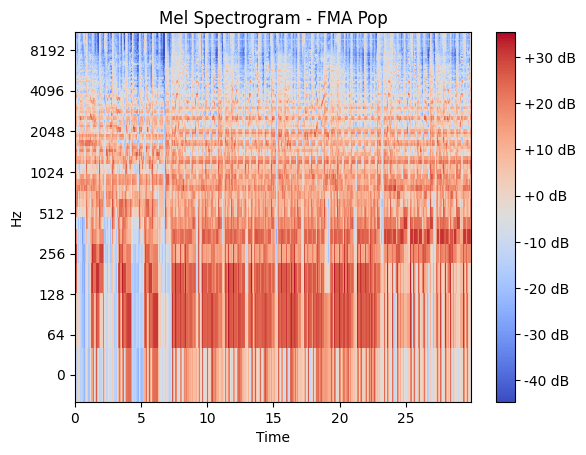

In [112]:
# Display spectrogram
librosa.display.specshow(mel_spectrograms['Pop'][0], sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram - FMA Pop')
plt.show()

# Converting mel spectrograms into images for the model training

## Method 1

In [113]:
# Set the desired image size
image_size = (128, 128)  # Adjust the size based on your model's input size

# Prepare empty dictionary to store converted spectrograms
converted_spectrograms = {}

# Convert spectrograms to image-like format
for label, spectrograms in mel_spectrograms.items():
    converted_spectrograms[label] = []  # Initialize empty list for this label
    for spectrogram in spectrograms:
        # Create an Image object from the spectrogram
        spectrogram_image = Image.fromarray(spectrogram)

        # Resize the image to the desired size
        resized_image = spectrogram_image.resize(image_size)

        # # Convert the image to RGB format
        rgb_image = resized_image.convert("RGB")

        # Convert the image to a tensor and normalize its values
        tensor_image = tf.convert_to_tensor(rgb_image, dtype=tf.float32)

        # Normalize the tensor image
        min = tf.reduce_min(tensor_image)
        max = tf.reduce_max(tensor_image)
        mean = tf.reduce_mean(tensor_image)
        std = tf.math.reduce_std(tensor_image)
        # print("Minimum, maximum pixel value, mean, std:", min, max, mean, std)
        normalized_tensor_image = (tensor_image - min) / (max - min)
        # normalized_tensor_image = (tensor_image - mean) / std

        # Append the tensor representation to the list for this label
        converted_spectrograms[label].append(normalized_tensor_image)

In [115]:
# # Code to make sure that the images are correctly normalized and has no NaN values
# for label, tensors in converted_spectrograms.items():
#     count = 0
#     for tensor in tensors:
#         min_val = tf.reduce_min(tensor)
#         max_val = tf.reduce_max(tensor)
#         # print("Minimum value:", min_val)
#         # print("Maximum value:", max_val)
#         has_nan = tf.math.reduce_any(tf.math.is_nan(tensor))
#         if has_nan:
#             count += 1
#             print("NaN values found in the tensor.", label)
# print(count)

# min_val = tf.reduce_min(tf.concat([tensor for tensors in converted_spectrograms.values() for tensor in tensors], axis=0))
# max_val = tf.reduce_max(tf.concat([tensor for tensors in converted_spectrograms.values() for tensor in tensors], axis=0))
# print(min_val, max_val)

### Method 2 - Using RGB/Grayscale as needed similar to CNN

In [35]:
# # Define target image dimensions
# image_width = 64
# image_height = 64
# num_channels = 3

# # Prepare empty dictionary to store converted spectrograms
# converted_spectrograms = {}

# # Convert spectrograms to image-like format
# for label, spectrograms in mel_spectrograms.items():
#     converted_spectrograms[label] = []  # Initialize empty list for this label
#     for spectrogram in spectrograms:
#         # Normalize the spectrogram to [0, 1]
#         spectrogram_normalized = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))

#         # Convert the spectrogram array to uint8 data type
#         spectrogram_uint8 = (spectrogram_normalized * 255).astype(np.uint8)

#         # Create a PIL image from the spectrogram array
#         spectrogram_image = Image.fromarray(spectrogram_uint8)

#         # # Convert the grayscale image to RGB
#         # spectrogram_image_rgb = spectrogram_image.convert('RGB')

#         # Convert the image to grayscale
#         spectrogram_image_gray = spectrogram_image.convert('L')

#         # Resize the image
#         image = spectrogram_image_gray.resize((image_width, image_height))

#         # Convert the image to a NumPy array
#         image_array = np.array(image)

#         # # Normalize the pixel values to [0, 1]
#         # image_array_normalized = image_array / 255.0

#         # # Add an extra dimension for the batch size if grayscale
#         # image_array = tf.expand_dims(image_array_normalized, axis=-1)

#         # # Convert the array to a TensorFlow tensor
#         # tensor_image = tf.convert_to_tensor(image_array)

#         # Append the converted tensor to the list for the current label
#         converted_spectrograms[label].append(image_array)

In [36]:
# # Define target image dimensions
# image_width = 64
# image_height = 64
# num_channels = 1

# # Prepare empty dictionary to store converted spectrograms
# converted_spectrograms = {}

# # Convert spectrograms to image-like format
# for label, spectrograms in mel_spectrograms.items():
#     converted_spectrograms[label] = []  # Initialize empty list for this label
#     for spectrogram in spectrograms:
#         # Normalize the spectrogram to [0, 1]
#         spectrogram_normalized = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))

#         # Convert the spectrogram array to uint8 data type
#         spectrogram_uint8 = (spectrogram_normalized * 255).astype(np.uint8)

#         # Create a PIL image from the spectrogram array
#         spectrogram_image = Image.fromarray(spectrogram_uint8)

#         # Convert the image to grayscale
#         spectrogram_image_gray = spectrogram_image.convert('L')

#         # Resize the image
#         image = spectrogram_image.resize((image_width, image_height))

#         # Convert the image to a NumPy array
#         image_array = np.array(image)

#         # Normalize the pixel values to [0, 1]
#         image_array_normalized = image_array / 255.0

#         # Add an extra dimension for the batch size
#         image_array = tf.expand_dims(image_array_normalized, axis=-1)

#         # Convert the array to a TensorFlow tensor
#         image_tensor = tf.convert_to_tensor(image_array)

#         converted_spectrograms[label].append(image_tensor)

<ipython-input-36-ae229b3071a7>:14: RuntimeWarning: invalid value encountered in true_divide
  spectrogram_normalized = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))


In [38]:
print(converted_spectrograms['Pop'][0].shape)

(64, 64, 1)


## LABEL ENCODING

### METHOD SIMILAR TO CNN

In [39]:
# Prepare empty lists to store the spectrograms and labels
X = []
y = []

# Iterate over the mel spectrograms
for label, spectrograms in converted_spectrograms.items():
    for spectrogram in spectrograms:
        X.append(spectrogram)
        y.append(label)

# Convert the lists to NumPy arrays
X = np.array(X)
y = np.array(y)
# X_normalized = (X - np.min(X)) / (np.max(X) - np.min(X))
# X = X_normalized

# Perform label encoding and one-hot encoding
label_encoder = LabelEncoder()
y_label_encoded = label_encoder.fit_transform(y)
y_one_hot_encoded = to_categorical(y_label_encoded)

In [40]:
# Verify the minimum and maximum values after normalization
min_val = np.min(X)
max_val = np.max(X)
print("Minimum value:", min_val)
print("Maximum value:", max_val)

Minimum value: 0.0
Maximum value: 0.9921568627450981


### METHOD 1

In [ ]:
# # Combine y_train and y_val for label encoding
# y_combined = pd.concat([y_train_initial, y_test_initial])

# # Perform label encoding
# label_encoder = LabelEncoder()
# y_combined_label_encoded = label_encoder.fit_transform(y_combined)

# # Split the label-encoded array back into y_train and y_val
# y_train_label_encoded = y_combined_label_encoded[:len(y_train_initial)]
# y_val_label_encoded = y_combined_label_encoded[len(y_train_initial):]

# # Convert label-encoded arrays to one-hot encoded arrays
# num_classes = len(label_encoder.classes_)
# y_train_onehot = tf.one_hot(y_train_label_encoded, depth=num_classes)
# y_val_onehot = tf.one_hot(y_val_label_encoded, depth=num_classes)

In [ ]:
# # Combine y_train, y_test, and y_val for label encoding
# y_combined = pd.concat([y_train_initial, y_test_initial, y_val_initial])

# # Perform label encoding
# label_encoder = LabelEncoder()
# y_combined_label_encoded = label_encoder.fit_transform(y_combined)

# # Split the label-encoded array back into y_train, y_test, and y_val
# y_train_label_encoded = y_combined_label_encoded[:y_train_initial.size]
# y_test_label_encoded = y_combined_label_encoded[y_train_initial.size:y_train_initial.size + y_test_initial.size]
# y_val_label_encoded = y_combined_label_encoded[y_train_initial.size + y_test_initial.size:]

# # Convert label-encoded arrays to one-hot encoded arrays
# num_classes = len(label_encoder.classes_)
# y_train_onehot = tf.one_hot(y_train_label_encoded, depth=num_classes)
# y_test_onehot = tf.one_hot(y_test_label_encoded, depth=num_classes)
# y_val_onehot = tf.one_hot(y_val_label_encoded, depth=num_classes)

In [ ]:
# print(len(y_train_onehot), len(y_test_onehot), len(y_val_onehot))

6397 800 800


### METHOD 2

In [ ]:
# y_train_values = y_train_initial.values
# y_test_values = y_test_initial.values
# y_val_values = y_val_initial.values

# # Perform label encoding
# label_encoder = LabelEncoder()
# y_train_label_encoded = label_encoder.fit_transform(y_train_values)
# y_test_label_encoded = label_encoder.transform(y_test_values)
# y_val_label_encoded = label_encoder.transform(y_val_values)

# # Convert label-encoded arrays to one-hot encoded arrays
# num_classes = len(label_encoder.classes_)
# y_train_onehot = to_categorical(y_train_label_encoded, num_classes=num_classes)
# y_test_onehot = tf.one_hot(y_test_label_encoded, depth=num_classes)
# y_val_onehot = to_categorical(y_val_label_encoded, num_classes=num_classes)

In [ ]:
# X_train = tf.stack(X_train_images[:3200])
# X_test = tf.stack(X_test_images[:400])
# X_val = tf.stack(X_val_images[:400])
# y_train = y_train_onehot[:3200]
# y_test = y_test_onehot[:400]
# y_val = y_val_onehot[:400]

# # Generate random permutation of indices
# train_indices = np.random.permutation(len(X_train))
# val_indices = np.random.permutation(len(X_val))
# test_indices = np.random.permutation(len(X_test))

# # Shuffle the data based on the generated indices
# X_train = tf.gather(X_train, train_indices)
# y_train = tf.gather(y_train, train_indices)
# X_test = tf.gather(X_test, test_indices)
# y_test = tf.gather(y_test, test_indices)
# X_val = tf.gather(X_val, val_indices)
# y_val = tf.gather(y_val, val_indices)

# # Print the shapes of the data arrays
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("X_val shape:", X_val.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)
# print("y_val shape:", y_val.shape)

X_train shape: (3200, 72, 72, 1)
X_test shape: (400, 72, 72, 1)
X_val shape: (400, 72, 72, 1)
y_train shape: (3200, 8)
y_test shape: (400, 8)
y_val shape: (400, 8)


In [ ]:
# print(type(X_train), type(X_train[0]), type(X_train_images), type(X_train_images[0]))

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'list'> <class 'tensorflow.python.framework.ops.EagerTensor'>


### If using ImageDataGenerator to augment - this did not give good results

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# # Create an ImageDataGenerator instance for training data with desired data augmentation settings
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255.0,  # Normalize pixel values between 0 and 1
#     rotation_range=10,  # Randomly rotate images by 10 degrees
#     width_shift_range=0.1,  # Randomly shift images horizontally by 10% of the width
#     height_shift_range=0.1,  # Randomly shift images vertically by 10% of the height
#     zoom_range=0.1  # Randomly zoom in on images by 10%
# )

# # Create an ImageDataGenerator instance for validation data with only rescaling
# val_datagen = ImageDataGenerator(
#     rescale=1.0/255.0  # Normalize pixel values between 0 and 1
# )

In [ ]:
# # Create the generator for training data
# train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# # Create the generator for validation data
# val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# VIT MODEL ARCHITECTURE

## Architecture 1

In [83]:
# from keras import layers

# def create_vit_model(input_shape, num_classes):
#     # Vision Transformer parameters
#     patch_size = 16 # size of the patches used for patch embedding
#     num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
#     embedding_dim = 256 # dimensionality of the patch embeddings and positional encodings.
#     num_heads = 8 # number of attention heads in the multi-head attention mechanism
#     mlp_dim = 512 # dimensionality of the feed-forward MLP layers in the transformer blocks
#     num_layers = 8 # number of transformer blocks in the model

#     # Patch embedding layer
#     inputs = layers.Input(shape=input_shape)
#     x = layers.Conv2D(embedding_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
#     x = layers.Reshape((-1, embedding_dim))(x)

#     # Positional encoding
#     positions = np.arange(num_patches)
#     positional_encoding = position_embedding(positions, embedding_dim)
#     positional_encoding = tf.cast(positional_encoding, dtype=tf.float32)  # Convert to float32
#     positional_encoding = tf.reshape(positional_encoding, (-1, num_patches, embedding_dim))  # Reshape to match x shape
#     x += positional_encoding

#     # Transformer layers
#     for _ in range(num_layers):
#         x = transformer_block(x, embedding_dim, num_heads, mlp_dim)

#     # Global average pooling - to reduce the spatial dimensions of the output
#     x = layers.GlobalAveragePooling1D()(x)

#     # Final classification layer - softmax activation function is used to produce the final class probabilities
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     # Create the model
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     return model

# # This function generates a positional encoding matrix based on the positions and embedding dimensions.
# # The positions are scaled by a factor based on the index and the embedding dimension.
# # The resulting matrix is then concatenated with sine and cosine functions of different frequencies.
# def position_embedding(positions, d_model):
#     angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
#     angle_rads = positions[:, np.newaxis] * angle_rates[np.newaxis, :]
#     sines = np.sin(angle_rads[:, 0::2])
#     cosines = np.cos(angle_rads[:, 1::2])
#     pos_encoding = np.concatenate([sines, cosines], axis=-1)
#     pos_encoding = pos_encoding[np.newaxis, ...]
#     pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)  # Explicitly cast to float32
#     return pos_encoding

# # This function represents a single transformer block.
# # It takes the input x along with the embedding dimension, number of attention heads, and MLP dimension as arguments.
# # Within the block, it applies multi-head attention to the input tensor, followed by a residual connection, layer normalization, and a feed-forward MLP.
# # Another residual connection, layer normalization, and dropout are applied before returning the output.
# def transformer_block(x, embedding_dim, num_heads, mlp_dim):
#     # Multi-head attention
#     attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(x, x)
#     attention_output = layers.Dropout(0.1)(attention_output)
#     x1 = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

#     # MLP
#     mlp_output = layers.Dense(units=mlp_dim, activation='relu')(x1)
#     mlp_output = layers.Dense(units=embedding_dim)(mlp_output)
#     mlp_output = layers.Dropout(0.1)(mlp_output)
#     x2 = layers.LayerNormalization(epsilon=1e-6)(x1 + mlp_output)

#     return x2

## Architecture 2

In [96]:
# from keras import layers

# def create_vit_model(input_shape, num_classes):
#     # Vision Transformer parameters
#     patch_size = 6  # Size of the patches used for patch embedding
#     num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
#     embedding_dim = 128  # Dimensionality of the patch embeddings and positional encodings
#     num_heads = 8  # Number of attention heads in the multi-head attention mechanism
#     mlp_dim = 256  # Dimensionality of the feed-forward MLP layers in the transformer blocks
#     num_layers = 6  # Number of transformer blocks in the model
#     dropout_rate = 0.1

#     # Patch embedding layer
#     inputs = layers.Input(shape=input_shape)
#     x = layers.Conv2D(embedding_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
#     x = layers.Reshape((-1, embedding_dim))(x)

#     # Positional encoding
#     positions = np.arange(num_patches)
#     positional_encoding = position_embedding(positions, embedding_dim)
#     positional_encoding = tf.cast(positional_encoding, dtype=tf.float32)  # Convert to float32
#     positional_encoding = tf.reshape(positional_encoding, (-1, num_patches, embedding_dim))  # Reshape to match x shape
#     x += positional_encoding

#     # Transformer layers
#     for _ in range(num_layers):
#         x = transformer_block(x, embedding_dim, num_heads, mlp_dim)

#     # Global average pooling - to reduce the spatial dimensions of the output
#     x = layers.GlobalAveragePooling1D()(x)

#     # Final classification layer - softmax activation function is used to produce the final class probabilities
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     # Create the model
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     return model

# # This function generates a positional encoding matrix based on the positions and embedding dimensions.
# # The positions are scaled by a factor based on the index and the embedding dimension.
# # The resulting matrix is then concatenated with sine and cosine functions of different frequencies.
# def position_embedding(positions, d_model):
#     angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model) // 2)) / np.float32(d_model))
#     angle_rads = positions[:, np.newaxis] * angle_rates[np.newaxis, :]
#     sines = np.sin(angle_rads[:, 0:d_model//2])
#     cosines = np.cos(angle_rads[:, d_model//2:])
#     pos_encoding = np.concatenate([sines, cosines], axis=-1)
#     pos_encoding = pos_encoding[np.newaxis, ...]
#     pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)
#     return pos_encoding

# # This function represents a single transformer block.
# # It takes the input x along with the embedding dimension, number of attention heads, and MLP dimension as arguments.
# # Within the block, it applies multi-head attention to the input tensor, followed by a residual connection, layer normalization, and a feed-forward MLP.
# # Another residual connection, layer normalization, and dropout are applied before returning the output.
# def transformer_block(x, embedding_dim, num_heads, mlp_dim):
#     # Multi-head attention
#     attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(x, x)
#     attention_output = layers.Dropout(0.1)(attention_output)
#     x1 = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

#     # MLP
#     mlp_output = layers.Dense(units=mlp_dim, activation='relu')(x1)
#     mlp_output = layers.Dense(units=embedding_dim)(mlp_output)
#     mlp_output = layers.Dropout(0.1)(mlp_output)
#     x2 = layers.LayerNormalization(epsilon=1e-6)(x1 + mlp_output)

#     return x2

## Architecture 3

In [101]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.num_heads, self.projection_dim)
        )
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )
        output = self.combine_heads(concat_attention)
        return output


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = tf.keras.Sequential(
            [
                Dense(mlp_dim, activation=tfa.activations.gelu),
                Dropout(dropout),
                Dense(embed_dim),
                Dropout(dropout),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training):
        inputs_norm = self.layernorm1(inputs)
        attn_output = self.att(inputs_norm)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = attn_output + inputs

        out1_norm = self.layernorm2(out1)
        mlp_output = self.mlp(out1_norm)
        mlp_output = self.dropout2(mlp_output, training=training)
        return mlp_output + out1

class VisionTransformer(tf.keras.Model):
    def __init__(
        self,
        image_size,
        patch_size,
        num_layers,
        num_classes,
        d_model,
        num_heads,
        mlp_dim,
        channels=3,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        num_patches = (image_size // patch_size) ** 2
        self.patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.d_model = d_model
        self.num_layers = num_layers

        self.rescale = Rescaling(1.0 / 255)
        self.pos_emb = self.add_weight(
            "pos_emb", shape=(1, num_patches + 1, d_model)
        )
        self.class_emb = self.add_weight("class_emb", shape=(1, 1, d_model))
        self.patch_proj = Dense(d_model)
        self.enc_layers = [
            TransformerBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]
        self.mlp_head = tf.keras.Sequential(
            [
                LayerNormalization(epsilon=1e-6),
                Dense(mlp_dim, activation=tfa.activations.gelu),
                Dropout(dropout),
                Dense(num_classes),
            ]
        )

    def extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_dim])
        return patches

    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        x = self.rescale(x)
        patches = self.extract_patches(x)
        x = self.patch_proj(patches)

        class_emb = tf.broadcast_to(
            self.class_emb, [batch_size, 1, self.d_model]
        )
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb

        for layer in self.enc_layers:
            x = layer(x, training)

        # First (class token) is used for classification
        x = self.mlp_head(x[:, 0])
        return x

# MODEL TRAINING

In [97]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot_encoded, test_size=0.2, random_state=42)

# Convert the NumPy arrays to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

print("X type and shape: ", type(X), X.shape)
print("y_one_hot_encoded and shape: ", type(y_one_hot_encoded), y_one_hot_encoded.shape)
print("X_train type and shape: ", type(X_train), X_train.shape)
print("X_val type and shape: ", type(X_val),X_val.shape)
print("y_train type and shape: ", type(y_val), y_train.shape)  # (number_of_samples, num_classes)
print("y_val type and shape: ", type(y_val), y_val.shape)  # (number_of_samples, num_classes)

X type and shape:  <class 'numpy.ndarray'> (7997, 64, 64, 1)
y_one_hot_encoded and shape:  <class 'numpy.ndarray'> (7997, 8)
X_train type and shape:  <class 'tensorflow.python.framework.ops.EagerTensor'> (6397, 64, 64, 1)
X_val type and shape:  <class 'tensorflow.python.framework.ops.EagerTensor'> (1600, 64, 64, 1)
y_train type and shape:  <class 'tensorflow.python.framework.ops.EagerTensor'> (6397, 8)
y_val type and shape:  <class 'tensorflow.python.framework.ops.EagerTensor'> (1600, 8)


## Architecture 1

In [98]:
# # Defining the input shape and number of classes
# input_shape = (64, 64, 1)  # Adjust the shape based on your spectrogram size (72, 72, 1) (64, 64, 3)
# num_classes = 8  # 8 genres
# model = create_vit_model(input_shape, num_classes)

## Architecture 3

In [102]:
model = VisionTransformer(
    image_size=64,
    num_classes=8,
    channels=1,
    dropout=0.1,
    patch_size=4, # 8-32
    num_layers=6, # 6-12
    d_model=64, #  128-1024
    num_heads=4, # 4-16
    mlp_dim=128, #256-1024
)

# model = VisionTransformer(
#     image_size=128,
#     num_classes=8,
#     channels=3,
#     dropout=0.1,
#     patch_size=6, # 8-32
#     num_layers=6, # 6-12
#     d_model=256, #  128-1024
#     num_heads=8, # 4-16
#     mlp_dim=128, #256-1024
# )

# Model Training

In [105]:
# Try multiple learning rates - 0.1, 0.01, 1e-3, 1e-4, 1e-5, 3e-4
adam_weight = tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)

# categorical cross entropy is labels are one hot encoded and from_logits=True since there is no softmax activation function in final layer
ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(
    loss=ce_loss,
    optimizer=adam_weight,
    metrics=["accuracy"],
)

# Define early stopping and reduce LR callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=3, verbose=True)

In [106]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 23s 138ms/step - loss: 2.0866 - accuracy: 0.1276 - val_loss: 2.0803 - val_accuracy: 0.1269
Epoch 2/50
100/100 [==============================] - 12s 118ms/step - loss: 2.0872 - accuracy: 0.1321 - val_loss: 2.0817 - val_accuracy: 0.1269
Epoch 3/50
100/100 [==============================] - 12s 117ms/step - loss: 2.0869 - accuracy: 0.1216 - val_loss: 2.0808 - val_accuracy: 0.1088
Epoch 4/50
100/100 [==============================] - 12s 115ms/step - loss: 2.0859 - accuracy: 0.1218 - val_loss: 2.0809 - val_accuracy: 0.1369
Epoch 5/50
100/100 [==============================] - 12s 116ms/step - loss: 2.0873 - accuracy: 0.1252 - val_loss: 2.0803 - val_accuracy: 0.1369
Epoch 6/50
100/100 [==============================] - 12s 116ms/step - loss: 2.0863 - accuracy: 0.1276 - val_loss: 2.0811 - val_accuracy: 0.1250
Epoch 7/50
100/100 [==============================] - 12s 118ms/step - loss: 2.0833 - accuracy: 0.1288 - val_loss: 2.0799 - val_ac

## Test Accuracy, Precision, Recall, F1 Score

In [76]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_val, y_val)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

50/50 [==============================] - 3s 28ms/step - loss: 1.7659 - accuracy: 0.3244
Test Loss: 1.7658796310424805
Test Accuracy: 0.3243750035762787


In [77]:
# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=top_level_genres, zero_division=0)

# Print the classification report
print(report)

50/50 [==============================] - 2s 18ms/step
               precision    recall  f1-score   support

          Pop       0.38      0.15      0.21       206
      Hip-Hop       0.24      0.04      0.07       201
         Rock       0.29      0.75      0.42       193
 Experimental       0.36      0.44      0.40       219
         Folk       0.48      0.28      0.36       200
 Instrumental       0.23      0.25      0.24       187
   Electronic       0.17      0.13      0.15       203
International       0.45      0.57      0.50       191

     accuracy                           0.32      1600
    macro avg       0.33      0.33      0.29      1600
 weighted avg       0.33      0.32      0.29      1600



## Loss & Accuracy Curve

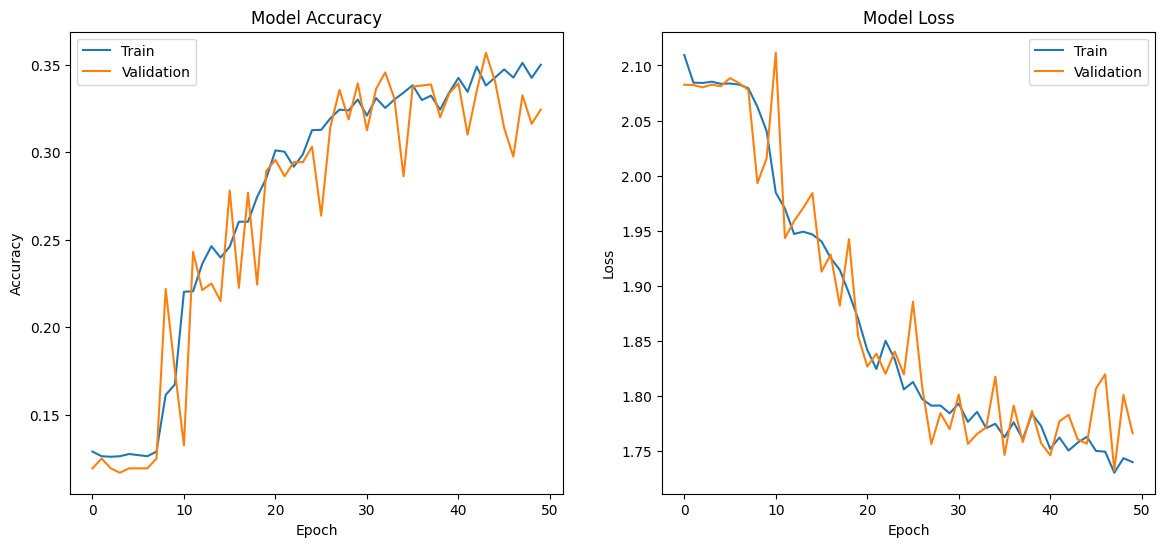

In [79]:
# Plotting accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

## Confusion Matrix

50/50 [==============================] - 1s 18ms/step


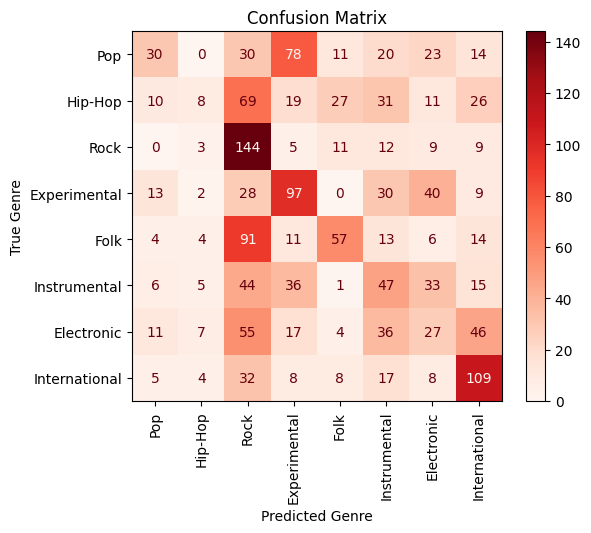

In [80]:
# Assuming you have the model and the validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

genres = top_level_genres

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
# Rotate xticks vertically
plt.xticks(rotation='vertical')
plt.show()